In [1]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as F
import matplotlib.pyplot as plt
from IPython.display import Audio
import IPython.display as ipd
from torchaudio.utils import download_asset

In [2]:
SAMPLE_WAV = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")
metadata = torchaudio.info(SAMPLE_WAV)
print(metadata)

AudioMetaData(sample_rate=16000, num_frames=54400, num_channels=1, bits_per_sample=16, encoding=PCM_S)


In [3]:
SAMPLE_WAV

'/home/levi/.cache/torch/hub/torchaudio/tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav'

In [4]:
wave_form, sampling_rate = torchaudio.load(SAMPLE_WAV)
wave_form = wave_form.numpy()
ipd.Audio(wave_form, rate=sampling_rate)

In [5]:
from audiomentations import TimeStretch

transform = TimeStretch(
	min_rate=0.8,
	max_rate=1.25,
	leave_length_unchanged=True,
	p=0.5
)

augmented_sound = transform(wave_form, sample_rate=sampling_rate)

In [6]:
from audiomentations import TimeStretch

transform = TimeStretch(
	min_rate=1.25,
	max_rate=1.25,
	leave_length_unchanged=True,
	p=1.0
)

augmented_sound = transform(wave_form, sample_rate=sampling_rate)
ipd.Audio(augmented_sound, rate=sampling_rate)

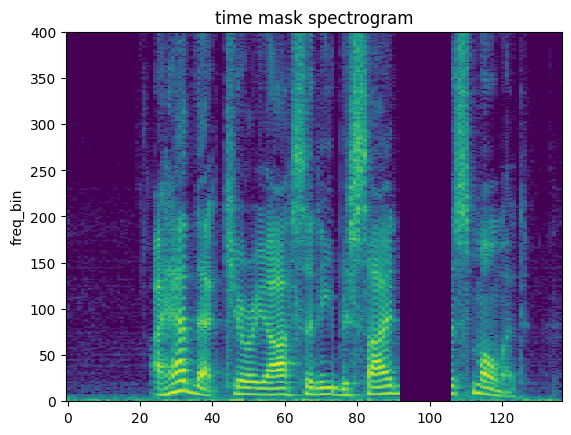

In [28]:
import random

def time_mask(spec, T=40, num_masks=1, p=0.2, pad_value=0):
    """Time masking

    :param torch.Tensor spec: input tensor with shape (dim, T)
    :param int T: maximum width of each mask
    :param int num_masks: number of masks
    :param bool pad_value: value for padding
    """
    cloned = spec.clone()
    len_spectro = cloned.shape[2]
    T = min(T, int(len_spectro * p / num_masks))

    for i in range(0, num_masks):
        t = random.randrange(0, T)
        t_zero = random.randrange(0, len_spectro - t)

        # avoids randrange error if values are equal and range is empty
        if (t_zero == t_zero + t):
            return cloned.squeeze(0)

        mask_end = random.randrange(t_zero, t_zero + t)
        cloned[0][:, t_zero:mask_end] = pad_value
    return cloned.squeeze(0)

time_mask_spec = time_mask(spectrogram)
plot_spectrogram(time_mask_spec, title="time mask spectrogram")


In [8]:
waveform, sample_rate = torchaudio.load(SAMPLE_WAV, normalize=True)


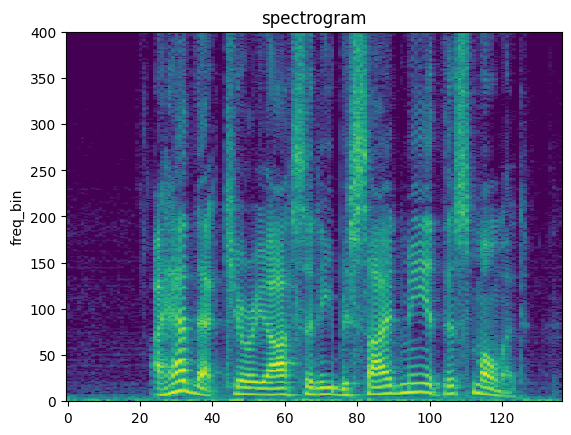

In [9]:
import librosa

transform = torchaudio.transforms.Spectrogram(n_fft=800)
spectrogram = transform(waveform)

def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")

plot_spectrogram(spectrogram[0], title="spectrogram")

In [15]:
spectrogram.shape

torch.Size([1, 401, 137])

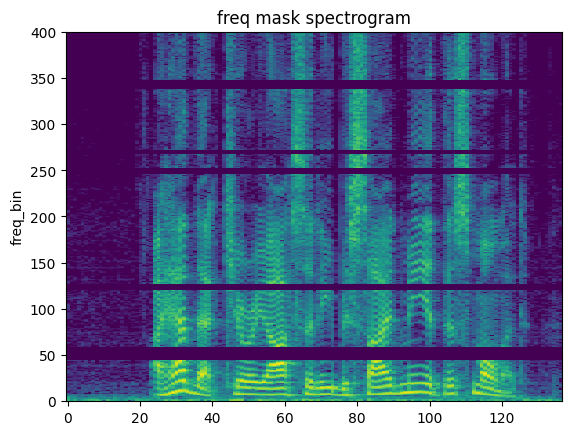

In [25]:
def freq_mask(spec, F=30, num_masks=5, pad_value=0):
    """Frequency masking

    :param torch.Tensor spec: input tensor with shape (dim, T)
    :param int F: maximum width of each mask
    :param int num_masks: number of masks
    :param bool pad_value: value for padding
    """
    cloned = spec.clone()
    num_mel_channels = cloned.shape[1]

    for i in range(0, num_masks):
        f = random.randrange(0, F)
        f_zero = random.randrange(0, num_mel_channels - f)

        # avoids randrange error if values are equal and range is empty
        if (f_zero == f_zero + f):
            return cloned.squeeze(0)

        mask_end = random.randrange(f_zero, f_zero + f)
        cloned[0][f_zero:mask_end] = pad_value

    return cloned.squeeze(0)
freq_mask_spec = freq_mask(spectrogram)
plot_spectrogram(freq_mask_spec, title="freq mask spectrogram")

In [42]:

def sparse_image_warp(img_tensor,
                      source_control_point_locations,
                      dest_control_point_locations,
                      interpolation_order=2,
                      regularization_weight=0.0,
                      num_boundaries_points=0):
    device = img_tensor.device
    control_point_flows = dest_control_point_locations - source_control_point_locations

    batch_size, image_height, image_width = img_tensor.shape
    flattened_grid_locations = get_flat_grid_locations(image_height, image_width, device)

    flattened_flows = interpolate_spline(
        dest_control_point_locations,
        control_point_flows,
        flattened_grid_locations,
        interpolation_order,
        regularization_weight)

    dense_flows = create_dense_flows(flattened_flows, batch_size, image_height, image_width)

    warped_image = dense_image_warp(img_tensor, dense_flows)

    return warped_image, dense_flows


def get_grid_locations(image_height, image_width, device):
    y_range = torch.linspace(0, image_height - 1, image_height, device=device)
    x_range = torch.linspace(0, image_width - 1, image_width, device=device)
    y_grid, x_grid = torch.meshgrid(y_range, x_range)
    return torch.stack((y_grid, x_grid), -1)


def flatten_grid_locations(grid_locations, image_height, image_width):
    return torch.reshape(grid_locations, [image_height * image_width, 2])


def get_flat_grid_locations(image_height, image_width, device):
    y_range = torch.linspace(0, image_height - 1, image_height, device=device)
    x_range = torch.linspace(0, image_width - 1, image_width, device=device)
    y_grid, x_grid = torch.meshgrid(y_range, x_range)
    return torch.stack((y_grid, x_grid), -1).reshape([image_height * image_width, 2])


def create_dense_flows(flattened_flows, batch_size, image_height, image_width):
    # possibly .view
    return torch.reshape(flattened_flows, [batch_size, image_height, image_width, 2])


def interpolate_spline(train_points, train_values, query_points, order, regularization_weight=0.0,):
    # First, fit the spline to the observed data.
    w, v = solve_interpolation(train_points, train_values, order, regularization_weight)
    # Then, evaluate the spline at the query locations.
    query_values = apply_interpolation(query_points, train_points, w, v, order)

    return query_values


def solve_interpolation(train_points, train_values, order, regularization_weight):
    device = train_points.device
    b, n, d = train_points.shape
    k = train_values.shape[-1]

    c = train_points
    f = train_values.float()

    matrix_a = phi(cross_squared_distance_matrix(c, c), order)  # [b, n, n]

    # Append ones to the feature values for the bias term in the linear model.
    #ones = torch.ones(1, dtype=train_points.dtype, device=device).view([-1, 1, 1])
    ones = torch.ones_like(c[:, :, :1], dtype=train_points.dtype, device=device)
    matrix_b = torch.cat((c, ones), 2).float()  # [b, n, d + 1]

    # [b, n + d + 1, n]
    left_block = torch.cat((matrix_a, torch.transpose(matrix_b, 2, 1)), 1)

    num_b_cols = matrix_b.shape[2]  # d + 1

    # In Tensorflow, zeros are used here. Pytorch solve fails with zeros for some reason we don't understand.
    # So instead we use very tiny randn values (variance of one, zero mean) on one side of our multiplication.
    lhs_zeros = 0 * torch.randn((b, num_b_cols, num_b_cols), device=device) / 1e10
    right_block = torch.cat((matrix_b, lhs_zeros), 1)  # [b, n + d + 1, d + 1]
    lhs = torch.cat((left_block, right_block), 2)  # [b, n + d + 1, n + d + 1]

    rhs_zeros = torch.zeros((b, d + 1, k), dtype=train_points.dtype, device=device).float()
    rhs = torch.cat((f, rhs_zeros), 1)  # [b, n + d + 1, k]

    # Then, solve the linear system and unpack the results.
    X = torch.linalg.solve(lhs, rhs)
    w = X[:, :n, :]
    v = X[:, n:, :]

    return w, v


def cross_squared_distance_matrix(x, y):
    """Pairwise squared distance between two (batch) matrices' rows (2nd dim).

        Computes the pairwise distances between rows of x and rows of y
        Args:
        x: [batch_size, n, d] float `Tensor`
        y: [batch_size, m, d] float `Tensor`
        Returns:
        squared_dists: [batch_size, n, m] float `Tensor`, where
        squared_dists[b,i,j] = ||x[b,i,:] - y[b,j,:]||^2
    """
    x_norm_squared = torch.sum(torch.mul(x, x), dim=-1).unsqueeze(2)
    y_norm_squared = torch.sum(torch.mul(y, y), dim=-1).unsqueeze(1)

    x_y_transpose = torch.bmm(x, y.transpose(1, 2))

    # squared_dists[b,i,j] = ||x_bi - y_bj||^2 = x_bi'x_bi- 2x_bi'x_bj + x_bj'x_bj
    squared_dists = x_norm_squared - 2 * x_y_transpose + y_norm_squared

    return squared_dists.float()


def phi(r, order):
    """Coordinate-wise nonlinearity used to define the order of the interpolation.

    See https://en.wikipedia.org/wiki/Polyharmonic_spline for the definition.
    Args:
    r: input op
    order: interpolation order
    Returns:
    phi_k evaluated coordinate-wise on r, for k = r
    """
    EPSILON = torch.tensor(1e-10, device=r.device)
    # using EPSILON prevents log(0), sqrt0), etc.
    # sqrt(0) is well-defined, but its gradient is not
    if order == 1:
        r = torch.max(r, EPSILON)
        r = torch.sqrt(r)
        return r
    elif order == 2:
        return 0.5 * r * torch.log(torch.max(r, EPSILON))
    elif order == 4:
        return 0.5 * torch.square(r) * torch.log(torch.max(r, EPSILON))
    elif order % 2 == 0:
        r = torch.max(r, EPSILON)
        return 0.5 * torch.pow(r, 0.5 * order) * torch.log(r)
    else:
        r = torch.max(r, EPSILON)
        return torch.pow(r, 0.5 * order)


def apply_interpolation(query_points, train_points, w, v, order):
    """Apply polyharmonic interpolation model to data.

    Given coefficients w and v for the interpolation model, we evaluate
    interpolated function values at query_points.
    Args:
    query_points: `[b, m, d]` x values to evaluate the interpolation at
    train_points: `[b, n, d]` x values that act as the interpolation centers
                    ( the c variables in the wikipedia article)
    w: `[b, n, k]` weights on each interpolation center
    v: `[b, d, k]` weights on each input dimension
    order: order of the interpolation
    Returns:
    Polyharmonic interpolation evaluated at points defined in query_points.
    """
    query_points = query_points.unsqueeze(0)
    # First, compute the contribution from the rbf term.
    pairwise_dists = cross_squared_distance_matrix(query_points.float(), train_points.float())
    phi_pairwise_dists = phi(pairwise_dists, order)

    rbf_term = torch.matmul(phi_pairwise_dists, w)

    # Then, compute the contribution from the linear term.
    # Pad query_points with ones, for the bias term in the linear model.
    ones = torch.ones_like(query_points[..., :1])
    query_points_pad = torch.cat((
        query_points,
        ones
    ), 2).float()
    linear_term = torch.matmul(query_points_pad, v)

    return rbf_term + linear_term


def dense_image_warp(image, flow):
    """Image warping using per-pixel flow vectors.

    Apply a non-linear warp to the image, where the warp is specified by a dense
    flow field of offset vectors that define the correspondences of pixel values
    in the output image back to locations in the  source image. Specifically, the
    pixel value at output[b, j, i, c] is
    images[b, j - flow[b, j, i, 0], i - flow[b, j, i, 1], c].
    The locations specified by this formula do not necessarily map to an int
    index. Therefore, the pixel value is obtained by bilinear
    interpolation of the 4 nearest pixels around
    (b, j - flow[b, j, i, 0], i - flow[b, j, i, 1]). For locations outside
    of the image, we use the nearest pixel values at the image boundary.
    Args:
    image: 4-D float `Tensor` with shape `[batch, height, width, channels]`.
    flow: A 4-D float `Tensor` with shape `[batch, height, width, 2]`.
    name: A name for the operation (optional).
    Note that image and flow can be of type tf.half, tf.float32, or tf.float64,
    and do not necessarily have to be the same type.
    Returns:
    A 4-D float `Tensor` with shape`[batch, height, width, channels]`
    and same type as input image.
    Raises:
    ValueError: if height < 2 or width < 2 or the inputs have the wrong number
    of dimensions.
    """
    image = image.unsqueeze(3)  # add a single channel dimension to image tensor
    batch_size, height, width, channels = image.shape
    device = image.device

    # The flow is defined on the image grid. Turn the flow into a list of query
    # points in the grid space.
    grid_x, grid_y = torch.meshgrid(
        torch.arange(width, device=device), torch.arange(height, device=device))

    stacked_grid = torch.stack((grid_y, grid_x), dim=2).float()

    batched_grid = stacked_grid.unsqueeze(-1).permute(3, 1, 0, 2)

    query_points_on_grid = batched_grid - flow
    query_points_flattened = torch.reshape(query_points_on_grid, [batch_size, height * width, 2])
    # Compute values at the query points, then reshape the result back to the
    # image grid.
    interpolated = interpolate_bilinear(image, query_points_flattened)
    interpolated = torch.reshape(interpolated, [batch_size, height, width, channels])
    return interpolated


def interpolate_bilinear(grid,
                         query_points,
                         name='interpolate_bilinear',
                         indexing='ij'):
    """Similar to Matlab's interp2 function.

    Finds values for query points on a grid using bilinear interpolation.
    Args:
    grid: a 4-D float `Tensor` of shape `[batch, height, width, channels]`.
    query_points: a 3-D float `Tensor` of N points with shape `[batch, N, 2]`.
    name: a name for the operation (optional).
    indexing: whether the query points are specified as row and column (ij),
      or Cartesian coordinates (xy).
    Returns:
    values: a 3-D `Tensor` with shape `[batch, N, channels]`
    Raises:
    ValueError: if the indexing mode is invalid, or if the shape of the inputs
      invalid.
    """
    if indexing != 'ij' and indexing != 'xy':
        raise ValueError('Indexing mode must be \'ij\' or \'xy\'')

    shape = grid.shape
    if len(shape) != 4:
        msg = 'Grid must be 4 dimensional. Received size: '
        raise ValueError(msg + str(grid.shape))

    batch_size, height, width, channels = grid.shape

    shape = [batch_size, height, width, channels]
    query_type = query_points.dtype
    grid_type = grid.dtype
    grid_device = grid.device

    num_queries = query_points.shape[1]

    alphas = []
    floors = []
    ceils = []
    index_order = [0, 1] if indexing == 'ij' else [1, 0]
    unstacked_query_points = query_points.unbind(2)

    for dim in index_order:
        queries = unstacked_query_points[dim]

        size_in_indexing_dimension = shape[dim + 1]

        # max_floor is size_in_indexing_dimension - 2 so that max_floor + 1
        # is still a valid index into the grid.
        max_floor = torch.tensor(size_in_indexing_dimension - 2, dtype=query_type, device=grid_device)
        min_floor = torch.tensor(0.0, dtype=query_type, device=grid_device)
        maxx = torch.max(min_floor, torch.floor(queries))
        floor = torch.min(maxx, max_floor)
        int_floor = floor.long()
        floors.append(int_floor)
        ceil = int_floor + 1
        ceils.append(ceil)

        # alpha has the same type as the grid, as we will directly use alpha
        # when taking linear combinations of pixel values from the image.

        alpha = torch.tensor((queries - floor), dtype=grid_type, device=grid_device)
        min_alpha = torch.tensor(0.0, dtype=grid_type, device=grid_device)
        max_alpha = torch.tensor(1.0, dtype=grid_type, device=grid_device)
        alpha = torch.min(torch.max(min_alpha, alpha), max_alpha)

        # Expand alpha to [b, n, 1] so we can use broadcasting
        # (since the alpha values don't depend on the channel).
        alpha = torch.unsqueeze(alpha, 2)
        alphas.append(alpha)

    flattened_grid = torch.reshape(grid, [batch_size * height * width, channels])
    batch_offsets = torch.reshape(torch.arange(batch_size, device=grid_device) * height * width, [batch_size, 1])

    # This wraps array_ops.gather. We reshape the image data such that the
    # batch, y, and x coordinates are pulled into the first dimension.
    # Then we gather. Finally, we reshape the output back. It's possible this
    # code would be made simpler by using array_ops.gather_nd.
    def gather(y_coords, x_coords, name):
        linear_coordinates = batch_offsets + y_coords * width + x_coords
        gathered_values = torch.gather(flattened_grid.t(), 1, linear_coordinates)
        return torch.reshape(gathered_values, [batch_size, num_queries, channels])

    # grab the pixel values in the 4 corners around each query point
    top_left = gather(floors[0], floors[1], 'top_left')
    top_right = gather(floors[0], ceils[1], 'top_right')
    bottom_left = gather(ceils[0], floors[1], 'bottom_left')
    bottom_right = gather(ceils[0], ceils[1], 'bottom_right')

    interp_top = alphas[1] * (top_right - top_left) + top_left
    interp_bottom = alphas[1] * (bottom_right - bottom_left) + bottom_left
    interp = alphas[0] * (interp_bottom - interp_top) + interp_top

    return interp


def specaug(spec, W=80, F=27, T=70, num_freq_masks=2, num_time_masks=2, p=0.2, replace_with_zero=False):
    """SpecAugment

    Reference: SpecAugment: A Simple Data Augmentation Method for Automatic Speech Recognition
        (https://arxiv.org/pdf/1904.08779.pdf)

    This implementation modified from https://github.com/zcaceres/spec_augment

    :param torch.Tensor spec: input tensor with the shape (T, dim)
    :param int W: time warp parameter
    :param int F: maximum width of each freq mask
    :param int T: maximum width of each time mask
    :param int num_freq_masks: number of frequency masks
    :param int num_time_masks: number of time masks
    :param bool replace_with_zero: if True, masked parts will be filled with 0, if False, filled with mean
    """
    if replace_with_zero:
        pad_value = 0
    else:
        pad_value = spec.mean()
    return time_mask(
        freq_mask(time_warp(spec.transpose(0, 1), W=W),
                  F=F, num_masks=num_freq_masks, pad_value=pad_value),
        T=T, num_masks=num_time_masks, p=p, pad_value=pad_value).transpose(0, 1)


def time_warp(spec, W=5):
    """Time warping

    :param torch.Tensor spec: input tensor with shape (dim, T)
    :param int W: time warp parameter
    """
    if W == 0:
        return spec
    spec = spec.unsqueeze(0)
    num_rows = spec.shape[1]
    spec_len = spec.shape[2]
    device = spec.device

    y = num_rows / 2.0

    point_to_warp = random.randrange(W, spec_len - W)

    # Uniform distribution from (0,W) with chance to be up to W negative
    dist_to_warp = random.randrange(-W, W)
    src_pts, dest_pts = (torch.tensor([[[y, point_to_warp], [0, 0], [0, spec_len - 1], [num_rows - 1, 0], [num_rows - 1, spec_len - 1]]], device=device),
                         torch.tensor([[[y, point_to_warp + dist_to_warp], [0, 0], [0, spec_len - 1], [num_rows - 1, 0], [num_rows - 1, spec_len - 1]]], device=device))
    warped_spectro, dense_flows = sparse_image_warp(spec, src_pts, dest_pts)
    return warped_spectro.squeeze(3).squeeze(0)

/tmp/ipykernel_305917/1160298215.py:290: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha = torch.tensor((queries - floor), dtype=grid_type, device=grid_device)


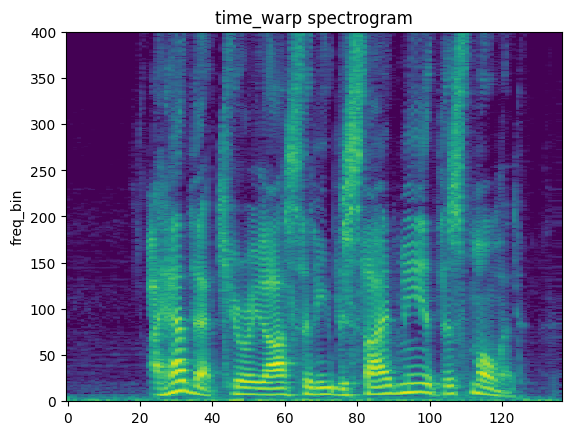

In [43]:
time_warp_spec = time_warp(spectrogram[0])
plot_spectrogram(time_warp_spec, title="time_warp spectrogram")